[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Luizfelz/Projeto_Final_Mod.06_PoloTech/blob/main/apresentacao_projeto_final_big_data.ipynb)


# Projeto Final - Módulo 6 - PoloTech
## Estudo de Caso: uso do ALS (Alternating Least Square) para criação de sistema de recomendação de produtos, com base em um dataset de produtos da Amazon.

### Integrantes do grupo:
- Gustavo Wohlers ([linkedin](https://www.linkedin.com/in/gustavo-wohlers-6689b6213/); [GitHub](https://github.com/GustavoWohlers))
- Karine Alves ([linkedin](https://www.linkedin.com/in/almeida-karine/); [GitHub](https://github.com/karibeam))
- Luiz Fonseca ([linkedin](https://www.linkedin.com/in/luizfsf/); [GitHub](https://github.com/Luizfelz))
- Maísa Santos ([linkedin](https://www.linkedin.com/in/maisalauriane/); [GitHub](https://github.com/MaisaLauriane))
- Pablo Brito ([linkedin](https://www.linkedin.com/in/pablo-brito-/); [GitHub](https://github.com/pabloxD13))
- Victor Hugo ([linkedin](https://www.linkedin.com/in/victor-hugo-chagas-9384201a2/); [Github](https://github.com/Viictor-Huugo))

---
### Objetivo do trabalho:

O objetivo do trabalho é fazer uso do Spark para manuseio, limpeza, organização e treinamento de um dataset sobre "reviews" de clientes da Amazon à respeito dos produtos relacionados à categoria de Vídeo Games.

---
### Introdução

##### • Indústria de games cresce no Brasil, e número de estúdios salta 169% em quatro anos;
"País abriga mais de mil unidades hoje, contra apenas 375 em 2018. Setor movimentou mais de US$ 2 bilhões no ano passado" 

Fonte: ([O Globo](https://oglobo.globo.com/economia/noticia/2022/07/industria-de-games-cresce-no-brasil-e-numero-de-estudios-salta-169percent-em-quatro-anos.ghtml), 2022)


Modelos de recomendação:

• Collaborative Filtering (Filtragem Colaborativa). Esse modelo consiste basicamente em analisar as relações que os produtos têm com o interesse das pessoas(possíveis consumidores), existem duas abordagens principais: baseada em usuário, em que procura-se por usuários com interesses semelhantes para fazer as recomendações, e a baseada em item, que procuram-se itens que estejam em uma categoria que o usuário costuma comprar e gostar. Porém, entre as principais dificuldades encontradas para implementação desse modelo, estão: esparsidade dos dados, escalabilidade, novos usuários, dentre outros;

![Tipos](https://www.researchgate.net/publication/340361119/figure/fig1/AS:962178941214731@1606412744374/Concepts-of-user-based-and-item-based-filtering.png)

• KNN (K-Nearest Neighbors). Pode ser utilizado para um sistema de recomendação baseado em seu princípio de indicar os vizinhos mais próximo daquele usuário em alvo. Ou seja, a partir de um usuário, pode-se implementar uma busca em que seus vizinhos próximos (por vizinho entende-se que tenham históricos de jogos parecidos) tenham alguns jogos que o usuário escolhido não tenha ainda jogado e a partir disso sugeri-lo. Uma das dificuldades para esse modelo nessa atividade é a escolha correta do número K, que irá afetar diretamente a qualidade das sugestões;  

• **ALS (Alternating Least Square)**: O ALS baseia-se na busca por duas matrizes, uma para os usuários e outra para os itens, em que a fatorização matricial tenta reduzir a dimensionalidade dos dados, e a partir disso conseguir as informações necessárias para a sugestão. A vantagem desse modelo consiste no fato dele conseguir lidar bem com dados esparsados e também com dados em larga escala, um ponto que pode vir a ser prejudicial é que o ALS costuma requerer grande processamento se comparado aos modelos mais simples de machine learning. 

---
### Datasets




Dentre os Datasets analisados, três se destacaram.

- Dois datasets são da Amazon:
  1. Digital Video Games
  - 70 MB
  - Aproximadamente 200 mil linhas
  2. Video Games
  - 1.12 GB
  - Aproximadamente 1.1 Milhão de linhas

  Ambas apresentam as seguintes estruturas:
 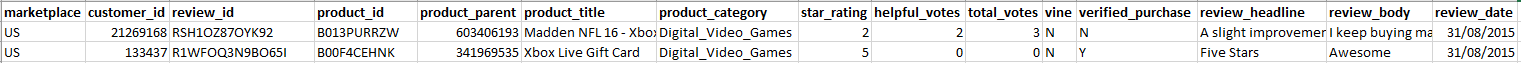

- O terceiro Dataset é de autoria do próprio grupo:

Para cria-lo foi desenvolvido uma aplicação em Web scraping, onde pegamos todos os jogos da Steam com suas respectivas Tags. 

As bibliotecas utilizadas na aplicação foram:


In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time
import pandas as pd

E a importação dos dados veio do site: https://steamdb.info/tags/
  3. Dataset STEAM
  - 45 MB
  - Aproximadamente 850 mil linhas

  Estrutura apresentada:

  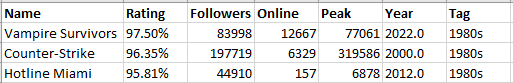

Download dos Datasets Analisados:

Link: https://drive.google.com/drive/folders/1KDzxPUb-g5Ps5YWCE6uGHUv4AE1Zrd9m

---
### Importações

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from fastapi import FastAPI, Depends
from pyspark.sql import Row
from enum import Enum
from pydantic import BaseModel
import pandas as pd
import numpy as np
import random

---
### _Starting Point_: SparkSession

In [ ]:
spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Projeto Amazon Videogames") \
    .getOrCreate()

---
### Importação do dataset utilizado

In [ ]:
# path do arquivo utilizado (dataset)
path = 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz'

# dataset original
dados = spark.read.format("csv")\
                .option("header","true")\
                .option("inferSchema", "true")\
                .option("delimiter", "\t")\
                .option("multiLine", "true")\
                .option("quote","\"")\
                .option("escape","\"")\
                .csv(path)

---
### Limpeza e organização do dataset

In [ ]:
# dataset sem as colunas desnecessárias
dados_2 = dados.select(['customer_id', 'review_id', 'product_id',
              'product_parent', 'product_title', 'star_rating'])

In [ ]:
# Quantidade de clientes totais no dataset original
dados.select('customer_id').distinct().count()

112891

In [ ]:
# Quantidade de produtos totais no dataset original
dados.select('product_title').distinct().count()

6946

In [ ]:
# usuários que fizeram 10 ou mais reviews
costumers_10_reviews = dados.groupBy('customer_id').agg(f.count('*').alias('count_reviews')).filter('count_reviews >= 10').orderBy('count_reviews', ascending=True)  

# produtos com mais de 5 reviews feitas
products_5_reviews = dados.groupBy('product_title').agg(f.count('*').alias('count_reviews')).filter('count_reviews >= 5').orderBy('count_reviews', ascending = True)

# filtrando apenas colunas específicas dos produtos com mais de 5 reviews
products_5_reviews = products_5_reviews.withColumnRenamed("count_reviews", "product_count_reviews")

# merge do dataset cujos produtos possuem mais de 5 reviews e do dataset que possui apenas as colunas que serão utilizadas
merged_data = dados.join(products_5_reviews, on="product_title", how="inner").select(dados_2["*"], f.col("product_count_reviews"))

# filtrando apenas as colunas específicas dos customers que fizeram 10 reviews ou mais reviews
costumers_10_reviews = costumers_10_reviews.withColumnRenamed("count_reviews", "product_count_reviews")

# merge do dataset cujos customers fizeram 10 reviews ou mais reviews e do dataset que possui apenas as colunas que serão utilizadas
merged_data_2 = dados.join(costumers_10_reviews, on="customer_id", how="inner").select(dados_2["*"], f.col("product_count_reviews"))

---
### Treinamento do modelo (ALS)

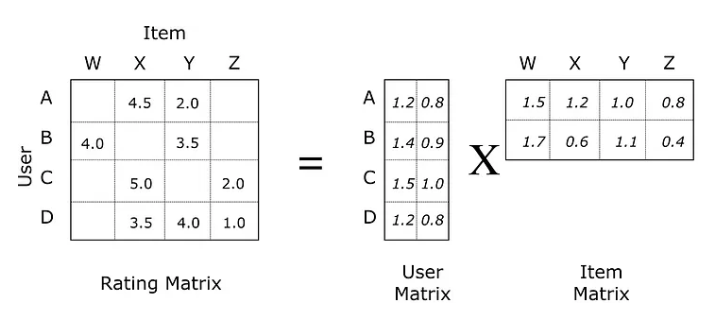

In [ ]:
# dividindo o treino e teste
(training, test) = merged_data_2.randomSplit([0.8, 0.2], seed = 42)

# configurando o modelo
als = ALS( userCol="customer_id", itemCol="product_parent", ratingCol="star_rating",
 coldStartStrategy="drop", nonnegative = True, implicitPrefs = False, seed = 42)

# treina o modelo com o dataset "training"
model = als.fit(training) 
#_____________________
# Faz as predições
predictions = model.transform(test)

# cria o "evaluator" para retornar o Erro Médio Quadrático
evaluator = RegressionEvaluator(metricName="rmse", labelCol="star_rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions) # variável que armazena o erro médio quatrático

In [ ]:
print("Erro médio quadrático = " + str(rmse))

Erro médio quadrático = 1.5423858073148673


---
### Criando as recomendações

In [ ]:
# Gera o top 10 recomendações de PRODUTOS para cada CUSTOMER
user_recs = model.recommendForAllUsers(10)

# Retorna um dataset com somente o Customers_ID e os ID's dos produtos recomendados para cada customer
user_recs_only_item_id = user_recs.select(user_recs['customer_id'], user_recs['recommendations']['product_parent'])

# Cria uma lista com todos os customers únicos
customer_ids = user_recs_only_item_id.select('customer_id').distinct().collect()

# Gera o top 10 recomendações de CUSTOMERS para cada PRODUTO
item_recs = model.recommendForAllItems(10)

# Retorna um dataset com somente as colunas selecionadas
user_check = merged_data_2.select(['customer_id', 'product_id', 'product_parent', 'product_title'])

# Retorna um dataset com somente o Product_Parent (id dos produtos) e os ID's dos customers recomendados para cada produto
item_recs_only_customer_id = item_recs.select(item_recs['product_parent'], item_recs['recommendations']['customer_id'])

# Cria uma lista com todos os produtos únicos
product_parents = item_recs_only_customer_id.select('product_parent').distinct().collect()

---
### Criando as Classes para uso nas funções das aplicações

In [ ]:
# class para usar na primeira função do predict_Game()
class ModelName1(str, Enum):
    w1 = customer_ids[0].customer_id
    w2 = customer_ids[1].customer_id
    w3 = customer_ids[2].customer_id
    w4 = customer_ids[3].customer_id
    w5 = customer_ids[4].customer_id
    
class Game(BaseModel):
    Customer_ID: ModelName1 = ModelName1.w1

# class para usar na segunda função do predict_Client()
class ModelName2(str, Enum):
    v1 = product_parents[0].product_parent
    v2 = product_parents[1].product_parent
    v3 = product_parents[2].product_parent
    v4 = product_parents[3].product_parent
    v5 = product_parents[4].product_parent
    
class Client(BaseModel):
    Product_ID: ModelName2 = ModelName2.v1

---
### Criação da primeira aplicação com o FastAPI

In [ ]:
# cria a aplicação FastAPI
app = FastAPI()

# define o endpoint para a previsão
@app.get("/predict_Game")
def predict_Game(Customer_ID: Game=Depends()):
    Customer_ID = str(Customer_ID)
    valor = Customer_ID.split(":")[1].strip(" '>") # (<' Customer_ID:8674867485 '>)
  
    # transforma a entrada em um array numpy
    random_customer_id = int(valor)
    
     # # cria um dataframe com somente o usuário escolhido e suas respectivas recomendações
    random_customer_df = user_recs_only_item_id.filter(user_recs_only_item_id.customer_id == random_customer_id)
    
    random_customer_pd = random_customer_df.toPandas()
    
    random_customer_pd.iloc[:1, 1]
    result_list = random_customer_pd.iloc[:1, 1].tolist()
    result_list = result_list[0]
    
    # # Retorna, do dataset original, as informações referentes aos ids dos produtos da lista "result_list"
    user_recommendations_df = dados.filter(f.col("product_parent").isin(result_list))
    
    # # Variável que guarda os nomes dos produtos recomendados para o customer_id
    recomendacao_usuario_aleatorio = user_recommendations_df.select('product_title').distinct().toPandas()


    # retorna a espécie prevista como uma resposta da API
    return {"Recomendação de produtos": recomendacao_usuario_aleatorio}

---
### Criação da segunda aplicação com o FastAPI

In [ ]:
# define o endpoint para a previsão
@app.get("/predict_Client")
def predict_Client(Product_ID: Client=Depends()):
    Product_ID = str(Product_ID)
    valor = Product_ID.split(":")[1].strip(" '>")
    
    # transforma a entrada em um array numpy
    random_product_id = int(valor)

    # # cria um dataframe com somente o produto escolhido e seus respectivos usuários recomendados
    random_product_df = item_recs_only_customer_id.filter(item_recs_only_customer_id.product_parent == random_product_id)

    # # cria um Pandas dataframe
    random_product_pd = random_product_df.toPandas()

    # # transforma somente a coluna em uma lista
    random_product_pd.iloc[:1, 1]
    result_list_item = random_product_pd.iloc[:1, 1].tolist()

    # # armazena o primeiro ID
    result_list_item = result_list_item[0]

    # # Retorna um dataframe contendo as informações sobre aquele produto
    item_recommendations_df = dados.filter(f.col("customer_id").isin(result_list_item))

    # # Variável que guarda os ids dos usuários recomendados para o produto
    recomendacao_produto_aleatorio = item_recommendations_df.select('customer_id').distinct().toPandas()
    recomendacao_produto_aleatorio = recomendacao_produto_aleatorio.values.tolist()

    # retorna a espécie prevista como uma resposta da API
    return {"Recomendação de clientes (ID's dos clientes)": recomendacao_produto_aleatorio}

---
### Conclusão - Pontos Importantes

Os sistemas de recomendação são extremamente importantes, além de serem extremamente úteis para ambos os lados: a empresa e o cliente. 

Para o cliente, um sistema de recomendação pode:
- auxiliar na compra de um produto que fosse realmente necessário e que não seria comprado caso não tivesse sido recomendado (ex: adaptadores);
- sugerir um produto com base no histório de compras e ajudar naqueles que estão indecisos do que comprar (ex: jogos, livros).

Para a empresa, um sistema de recomendação pode:
- auxiliar em estratégias de indicações de produtos específicos, com objetivo de alcançar aqueles clientes mais propensos a comprar determinado produto (aumentar as vendas);
- ajudar a entender os grupo de clientes e suas similaridades para auxiliar em recomendações para novos clientes que buscam determinado produto e ainda não possuem histórico de compras. 


---
### Referências

- AMAZON. **Amazon Customer Reviews Dataset**. Disponível em: https://s3.amazonaws.com/amazon-reviews-pds/readme.html. Acesso em 23 de abril de 2023.


- CHEN, Y.; HUI, L.; THAIPISUTIKUL, T. A collaborative filtering recommendation system with dynamic time decay. **The Journal of Supercomputing**, v. 77(1), p. 244-262, 2020. DOI: 10.1007/s11227-020-03266-2.


- GLOBO. **Indústria de games cresce no Brasil, e número de estúdios salta 169% em quatro anos**. Disponível em: https://oglobo.globo.com/economia/noticia/2022/07/industria-de-games-cresce-no-brasil-e-numero-de-estudios-salta-169percent-em-quatro-anos.ghtml. Acesso em 23 de abril de 2023.


- GOMES, P. H. A. **Sistemas de Recomendação Usando Collaborative Filtering**. Disponível em: https://lamfo-unb.github.io/2018/09/29/Sistemas-de-Recomenda%C3%A7%C3%A3o-usando-Collaborative-Filtering/. Acesso em 22 de abril de 2023.


- KORDÍK, Pavel. **Machine Learning for Recommender systems — Part 1** (algorithms, evaluation and cold start). Disponível em: https://medium.com/recombee-blog/machine-learning-for-recommender-systems-part-1-algorithms-evaluation-and-cold-start-6f696683d0ed. Acesso em 22 de abril de 2023.


- LIAO, Kevin. **Prototyping a Recommender System Step by Step Part 2**: Alternating Least Square (ALS) Matrix Factorization in Collaborative Filtering. Disponível em: https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1. Acesso em 23 de abril de 2023.


- RODRIGUES, M. M. M. **Algoritmos de recomendação: mais presente no dia a dia do que você pensa**. Disponível em: http://www.each.usp.br/petsi/jornal/?p=2684. Acesso em 23 de abril de 2023.